## 1: Face Recognition, but not evil this time

Using the faces dataset in:

```
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
```

If you use the `faces.target` and `faces.target_names` attributes, you can build a facial recognition algorithm.

Use sklearn **gridsearch** (or an equivalent, like random search) to optimize the model for accuracy. Try both a SVM-based classifier and a logistic regression based classifier (with a feature pipeline of your choice) to get the best model. You should have at least 80% accuracy.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_lfw_people
import pandas as pd

In [2]:
faces = fetch_lfw_people(min_faces_per_person=60)

### Who are these people?

In [3]:
faces.target_names

array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Junichiro Koizumi',
       'Tony Blair'], dtype='<U17')

In [4]:
faces.target

array([1, 3, 3, ..., 7, 3, 5], dtype=int64)

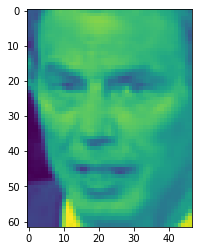

In [5]:
plt.imshow(faces['images'][np.random.randint(479)]);

In [6]:
# separate data into X and y
X = faces.data; y = faces.target
print(X.shape)
y.shape

(1348, 2914)


(1348,)

In [7]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [8]:
scalar = MinMaxScaler()  # instantiate MinMaxScalar

In [9]:
# scale the images (i.e. the rows of X)
X = np.transpose(scalar.fit_transform(np.transpose(X)))

In [10]:
from sklearn.model_selection import train_test_split

### Split the data into training and test partitions and use the test as the holdout set

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [12]:
from sklearn.svm import SVC

In [13]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV

# Support Vector Machine

### Create a pipeline with separate grids to eliminate useless recalculations. For example, "degree" is only used for kernel="poly" and ignored otherwise. If we use only one universal grid, "degree" will be applied to all kernels blindly.

In [16]:
pipe = Pipeline([
    ('svmmodel', SVC())])

param_grid = [
    # the linear grid:
    {'svmmodel__C': [1, 1E3, 1E6, 1E10],
     'svmmodel__kernel': ['linear']},
    # the rbf & sigmoid grid:
    {'svmmodel__C': [1, 1E3, 1E6, 1E10],
     'svmmodel__kernel': ['rbf', 'sigmoid'],
     'svmmodel__gamma': ['scale', 'auto']},
    # the poly grid:
    {'svmmodel__C': [1, 1E3, 1E6, 1E10],
     'svmmodel__degree': [3, 4, 5],
     'svmmodel__kernel': ['poly'],
     'svmmodel__gamma': ['scale', 'auto']}
    ]

### Run the grid

In [17]:
grid = GridSearchCV(pipe, param_grid, cv=7, n_jobs=4)
grid.fit(X_train, y_train)
grid.best_params_

{'svmmodel__C': 1000.0, 'svmmodel__gamma': 'auto', 'svmmodel__kernel': 'rbf'}

### Dump results in a dataframe just to look at them

In [18]:
df = pd.DataFrame(grid.cv_results_).sort_values('mean_test_score', ascending=False)

In [19]:
df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_svmmodel__C', 'param_svmmodel__kernel', 'param_svmmodel__gamma',
       'param_svmmodel__degree', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'split5_test_score', 'split6_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score'],
      dtype='object')

In [20]:
cols = ['C', 'kernel', 'gamma', 'degree', 'mean_test_score', 'std_test_score', 'rank_test_score']

In [21]:
df.columns = ['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'C', 'kernel', 'gamma', 'degree', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'split5_test_score', 'split6_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score']

In [22]:
df[cols].head(10)

,C,kernel,gamma,degree,mean_test_score,std_test_score,rank_test_score
14,1e+06,rbf,auto,NaN,0.845649,0.035022,1
18,1e+10,rbf,auto,NaN,0.845649,0.035022,1
10,1000,rbf,auto,NaN,0.845649,0.035022,1
0,1,linear,NaN,NaN,0.835783,0.019623,4
2,1e+06,linear,NaN,NaN,0.835783,0.019623,4
3,1e+10,linear,NaN,NaN,0.835783,0.019623,4
1,1000,linear,NaN,NaN,0.835783,0.019623,4
16,1e+10,rbf,scale,NaN,0.827867,0.035628,8
8,1000,rbf,scale,NaN,0.827867,0.035628,8
12,1e+06,rbf,scale,NaN,0.827867,0.035628,8


### Check the best configuration

In [23]:
print(grid.best_estimator_)
print(grid.best_params_)

Pipeline(steps=[('svmmodel', SVC(C=1000.0, gamma='auto'))])
{'svmmodel__C': 1000.0, 'svmmodel__gamma': 'auto', 'svmmodel__kernel': 'rbf'}


### Get the test score

In [24]:
grid.score(X_test, y_test)

0.8338278931750742

# Logistic Regression

In [15]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

### Define the pipeline

In [18]:
pipelog = Pipeline([

    ('pca', PCA()),
    ('logreg', LogisticRegression(n_jobs=4,
                                  max_iter=2_000,
                                  penalty='elasticnet',
                                  solver='saga'))
])

param_grid_log = [
    {
    'pca__n_components': [50, 100, 150, 200],
    'pca__whiten': [True, False],
    'pca__svd_solver': ['randomized'],

    'logreg__C': [1.0, 10, 100, 10000],
    'logreg__l1_ratio': [0.0, 0.3, 0.5, 0.75, 1.0],
#        'logreg__l1_ratio': [0., 0.5, 1.0], # chose 0.5
#        'logreg__penalty': ['l2'],
#        'logreg__dual': [True],
#        'logreg__solver': ['saga'],
#        'logreg__intercept_scaling': [10],
}]

### Run it

In [19]:
gridlog = GridSearchCV(pipelog, param_grid_log, cv=5, n_jobs=4, verbose=3)
gridlog.fit(X_train, y_train)
gridlog.best_params_

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   10.3s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:  5.1min
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed: 14.1min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed: 27.5min
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed: 28.0min finished


{'logreg__C': 1.0,
 'logreg__l1_ratio': 0.0,
 'pca__n_components': 200,
 'pca__svd_solver': 'randomized',
 'pca__whiten': False}

In [20]:
print(gridlog.best_estimator_)
print(gridlog.best_params_)

Pipeline(steps=[('pca', PCA(n_components=200, svd_solver='randomized')),
                ('logreg',
                 LogisticRegression(l1_ratio=0.0, max_iter=2000, n_jobs=4,
                                    penalty='elasticnet', solver='saga'))])
{'logreg__C': 1.0, 'logreg__l1_ratio': 0.0, 'pca__n_components': 200, 'pca__svd_solver': 'randomized', 'pca__whiten': False}


### Get the score

In [21]:
gridlog.score(X_test, y_test)

0.8308605341246291

# 2: Bag of Words, Bag of Popcorn

By this point, you are ready for the [Bag of Words, Bag of Popcorn](https://www.kaggle.com/c/word2vec-nlp-tutorial/data) competition. 

Use NLP feature pre-processing (using, SKLearn, Gensim, Spacy or Hugginface) to build the best classifier you can. Use a  feature pipeline, and gridsearch for your final model.

A succesful project should get 90% or more on a **holdout** dataset you kept for yourself.

## Summary of trials
### Many tactics were taken. Gensim and TF-IDF were both used along with LGBM. Customized stop words were created starting from the nltk list but these were ultimately not used. Gensim was not in the final version. The code below reflects all of the attempts but the parameter settings are for the final version.
### Feature engineering is included in the pipeline in the form of a paragraph segmentation. A Stanford paper found that the critical sentences of a review were at the beginning and ending of a paragraph and so this was varied in an attempt to fish out the sentiment. But in the end, this too did not do so well as the optimized sentence length ended up being pretty much the full paragraph in most cases.
### However, I did learn of a method to embed feature engineering into a pipeline and that was worth it!

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
import gensim.downloader as model_api
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report,plot_confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import re
import pandas as pd
import lightgbm as lgbm
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup 

In [41]:
nltk.download('wordnet');
nltk.download('stopwords');

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Pinhead\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pinhead\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Custom stop words

In [42]:
from nltk.corpus import stopwords

In [43]:
print(stopwords.words('English'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [44]:
to_remove_from_stop = ['above', 'below', 'up', 'down', 'over', 'under', 'again', 
                       'more', 'most', 'no', 'not', 'only', 'too', 'very', "do", 
                       "don't", 'should', 'shouldn', "shouldn't", 'wasn', "wasn't", 
                       'weren', "weren't",'won', "won't", 'wouldn', "wouldn't"]

In [45]:
my_stop_words = stopwords.words('English')
for w in to_remove_from_stop:
    my_stop_words.remove(w)
print(my_stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'to', 'from', 'in', 'out', 'on', 'off', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'other', 'some', 'such', 'nor', 'own', 'same', 'so', 'than', 's', 't', 'can', 'will', 'just', 'don', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain

### Select Gensim word model (not used in final version)

In [46]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [47]:
#word_vectors = model_api.load("glove-wiki-gigaword-200")
#word_vectors = model_api.load("glove-wiki-gigaword-100")
#word_vectors = model_api.load("glove-twitter-100")
#word_vectors = model_api.load("glove-twitter-200")

### Read in data

In [48]:
df = pd.read_table('labeledTrainData.tsv')

In [49]:
df.sample(8)

,id,sentiment,review
17618,10073_10,1,One of the great things about many of the supe...
7016,8786_8,1,James J. Corbett's autobiography \The Roar of ...
11269,1208_9,1,Every kid has that movie that he pops into VHS...
7311,5144_10,1,This very strange movie is unlike anything mad...
23912,2810_4,0,I'm surprised about the many female voters who...
13088,11569_8,1,Bob Clampett's 'An Itch in Time' milks seven m...
14472,655_1,0,"I went into this with my hopes up, by twenty m..."
20906,5431_3,0,This is your typical Priyadarshan movie--a bun...


### Get rid of html and perform other cleaning of words

In [50]:
# this code appears in many sites on internet and I took it and modified it for the stop words
lemmatizer = WordNetLemmatizer()

# function that receive a list of words and do lemmatization:
def lemma_stem_text(words_list):
    # Lemmatizer
    # eighties->eight or messages->message or drugs->drug
    text = [lemmatizer.lemmatize(token.lower()) for token in words_list]
    # going-> go or started->start or watching->watch
    text = [lemmatizer.lemmatize(token.lower(), "v") for token in text]
    return text

re_negation = re.compile("n't ")

# function that receive a sequence of woords and return the same sequence transforming
# abbreviated negations to the standard form.
def negation_abbreviated_to_standard(sent):
    sent = re_negation.sub(" not ", sent)
    return sent

def review_to_words(raw_review):
    # 1. Remove HTML tags
    review_text = BeautifulSoup(raw_review).get_text() 

    # 2. Transform abbreviated negations to the standard form.
    review_text = negation_abbreviated_to_standard(review_text)

    # 3. Remove non-letters and non-numbers   
    letters_numbers_only = re.sub("[^a-zA-Z_0-9]", " ", review_text) 
    
    # 4. Convert to lower case and split into individual words (tokenization)
    words = np.char.lower(letters_numbers_only.split())                             

    # 5. Remove stop words
    # stop words not used in final version
#    meaningful_words = [w for w in words if not w in my_stop_words]   
    meaningful_words = [w for w in words]   

    # 6. Apply lemmatization function
    lemma_words = lemma_stem_text(meaningful_words)
    
    # 7. Join the words back into one string separated by space, and return the result.
    return( " ".join(lemma_words))   

In [51]:
words = df.review.apply(review_to_words).str.split()
words = pd.DataFrame(words.tolist())
words

,0,1,2,3,4,5,6,7,8,9,...,2488,2489,2490,2491,2492,2493,2494,2495,2496,2497
0,with,all,this,stuff,go,down,at,the,moment,with,...,None,None,None,None,None,None,None,None,None,None
1,the,classic,war,of,the,world,by,timothy,hines,be,...,None,None,None,None,None,None,None,None,None,None
2,the,film,start,with,a,manager,nicholas,bell,give,welcome,...,None,None,None,None,None,None,None,None,None,None
3,it,must,be,assume,that,those,who,praise,this,film,...,None,None,None,None,None,None,None,None,None,None
4,superbly,trashy,and,wondrously,unpretentious,80,s,exploitation,hooray,the,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,it,seem,like,more,consideration,ha,go,into,the,imdb,...,None,None,None,None,None,None,None,None,None,None
24996,i,do,not,believe,they,make,this,film,completely,unnecessary,...,None,None,None,None,None,None,None,None,None,None
24997,guy,be,a,loser,ca,not,get,girl,need,to,...,None,None,None,None,None,None,None,None,None,None
24998,this,30,minute,documentary,bu,uel,make,in,the,early,...,None,None,None,None,None,None,None,None,None,None


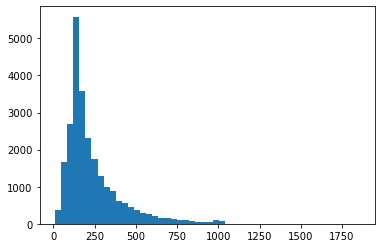

In [52]:
# see how long (word count) are the reviews
is_missing = words.isna().values
# first Nan is the location where the first None appears 
# hence, the end of the review.
first_nan = np.where(is_missing.any(1), is_missing.argmax(1), np.nan)
plt.hist(first_nan,bins=50);

### Create a new dataframe like "words" but with an additional column that represents the number of non-Nan columns in each row. Call this column frst_nan.

In [53]:
words_fl = pd.concat([words,
                      pd.Series(first_nan,
                                name='frst_nan',
                                dtype=int)
                      .fillna(value=words.shape[1]-1)
                      .astype(int)], axis=1)
words_fl

,0,1,2,3,4,5,6,7,8,9,...,2489,2490,2491,2492,2493,2494,2495,2496,2497,frst_nan
0,with,all,this,stuff,go,down,at,the,moment,with,...,None,None,None,None,None,None,None,None,None,438
1,the,classic,war,of,the,world,by,timothy,hines,be,...,None,None,None,None,None,None,None,None,None,161
2,the,film,start,with,a,manager,nicholas,bell,give,welcome,...,None,None,None,None,None,None,None,None,None,379
3,it,must,be,assume,that,those,who,praise,this,film,...,None,None,None,None,None,None,None,None,None,385
4,superbly,trashy,and,wondrously,unpretentious,80,s,exploitation,hooray,the,...,None,None,None,None,None,None,None,None,None,381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,it,seem,like,more,consideration,ha,go,into,the,imdb,...,None,None,None,None,None,None,None,None,None,91
24996,i,do,not,believe,they,make,this,film,completely,unnecessary,...,None,None,None,None,None,None,None,None,None,182
24997,guy,be,a,loser,ca,not,get,girl,need,to,...,None,None,None,None,None,None,None,None,None,131
24998,this,30,minute,documentary,bu,uel,make,in,the,early,...,None,None,None,None,None,None,None,None,None,206


## Define some functions for feature engineering

In [54]:
def shift_row(row, sntc_ln=100):
    """
    From each row (review) take 
    the first and last sentence (word
    count) as defined by sntc_ln.
    """
    # get the first occurence of None
    # for this row.
    frst_nan = row['frst_nan']
    # if review is less than two 
    # sentences long, take the
    # columns up to 2 * sentence length
    if frst_nan <= 2*sntc_ln:
        return row.iloc[:int(2*sntc_ln)].values
    # else ...
    else:
        # grab first sentence length
        sen1 = row.iloc[:sntc_ln]
        # grab the last sentence length
        sen2 = row.iloc[frst_nan-sntc_ln-1:frst_nan-1]
        return np.concatenate((sen1,sen2))

def soft_get(w):
    """
    Convert a single word to a 
    word vector as provided by
    the loaded gensim model.
    """
    try:
        # retrieve the word vector if it exists
        return word_vectors[w]
    except KeyError:
        # fill the vector space with zeros otherwise
        # - justified because we are summing the 
        #   word vectors in map_vectors
        return np.zeros(word_vectors.vector_size)

def map_vectors(row, take_mean=True):
    """
    Convert a row of words (with some NaN's)
    to the sum of these word vectors
    according to the gensim model.
    """
    if np.sum(row.notna()) == 0:
        # if entirely zeros, return zeros
        # - but this should be eliminated 
        #   at some point to avoid singular matrix
        return np.zeros(word_vectors.vector_size)
    if take_mean:
        try:
            # otherwise, return the mean of the 
            # word vectors
            return np.mean(
                row.loc[row.notna()].apply(soft_get)
            )
        except:
            # if error return zeros
            return np.zeros(word_vectors.vector_size)
    else:
        try:
            # otherwise, return the sum of the 
            # word vectors
            return np.sum(
                row.loc[row.notna()].apply(soft_get)
            )
        except:
            # if error return zeros
            return np.zeros(word_vectors.vector_size)

## Define a class for feature engineering

In [55]:
class SelectSentences(BaseEstimator, TransformerMixin):
    """
    Create a class of inheritance from 
    BaseEstimator and TransformerMixin in
    order to get the .fit and .transform
    methods.
    This will allow us to perform feature
    engineering with these methods and
    then use the class in a pipeline
    """
    def __init__(self, use_gensim=True, 
                 take_mean=True, 
                 stnd_rows=False, 
                 sntc_len=100): # no *args or **kargs
        self.sntc_len = sntc_len # length of sentence to use for 1st and last
        self.take_mean = take_mean # whether to take mean of sum of vectors for gensim
        self.stnd_rows = stnd_rows # whether to standardize rows or not for gensim
        self.use_gensim = use_gensim # whether of not to use gensim
        
    def fit(self, X, y=None):
        return self # nothing else to do
    
    def transform(self, X):
        # Do all the feature engineering
        # we want to do here.
        # In our case, the function was
        # already defined. Just call it.
        
        # create the series where only
        # the required # of words in each
        # row are retained.
        X_sntc = X.apply(shift_row, 
                         args=(self.sntc_len,), 
                         axis=1)
        if self.use_gensim:
            X_sntc = pd.DataFrame(X_sntc.to_list())
        else:
            X_sntc = pd.DataFrame(X_sntc)
            X_sntc = X_sntc[0].agg(lambda x: ','.join(map(str, x)).replace(',',' ')).to_list()
        
        if self.use_gensim:
            # Apply the word vector transformation
            # using either the sum or mean of 
            # the word vectors.
            X_sntc = pd.DataFrame(X_sntc.apply(map_vectors, 
                                               args=(self.take_mean,),
                                               axis=1)
                                  .tolist())
            # Finally, take the MinMaxScaler of 
            # each row if called for.
            X_sntc = X_sntc.to_numpy()
            if self.stnd_rows:
                scalar = MinMaxScaler()
                scalar.fit(np.transpose(X_sntc))
                X_sntc = scalar.transform(np.transpose(X_sntc))
                X_sntc = np.transpose(X_sntc)
        return X_sntc

### Create the X and y and split into X_train and X_test variables.

In [56]:
X = words_fl.copy()
y = df.sentiment.values

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=9)

## Define GridSearchCV parameters

In [60]:
pipe = Pipeline([
    ('feat_eng', SelectSentences()),
    ('tfidf', TfidfVectorizer()),
    ('logreg', LogisticRegression(n_jobs=4,
                                  max_iter=2_000))
 ])

param_grid = [
    {
        # Feature engineering params
        'feat_eng__sntc_len': [50, 100, 300, 500, 600], # chosen 500
        # the following were feature engineering parameters for 
        # Gensim but were not used in final cut
        'feat_eng__use_gensim': [False],
        'feat_eng__take_mean': [False], # only for gensim
        'feat_eng__stnd_rows': [False], # only for gensim
        
        # TF-IDF params
        'tfidf__max_df': [0.7, 0.8, 0.9, 0.95], # little influence
        'tfidf__min_df': [1, 5], # little influence
        'tfidf__max_features': [500, 1000, 5000], # significant influence
        'tfidf__sublinear_tf': [True],  # significant influence
        'tfidf__ngram_range': [(1,2)],  # useful in (2,2) format
        'tfidf__stop_words': [None],
        'tfidf__smooth_idf': [False],
#        'tfidf__use_idf': [False],
#        'tfidf__norm': ['l1'],
#        'tfidf__strip_accents': ['ascii', 'unicode'],
#        'logreg__l1_ratio': [0., 0.5, 1.0], # chose 0.5
#        'logreg__l1_ratio': [0.5],
        'logreg__penalty': ['l2'],
        'logreg__C': [1, 1000, 1000000, 1000000000] # chose 1
}]

In [61]:
grid = GridSearchCV(pipe, param_grid, cv=2, n_jobs=4, verbose=3)
grid.fit(X_train, y_train)
print(grid.best_params_)
grid.score(X_test, y_test)

Fitting 2 folds for each of 480 candidates, totalling 960 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  9.9min
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed: 23.0min
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed: 46.3min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed: 93.0min
[Parallel(n_jobs=4)]: Done 960 out of 960 | elapsed: 127.5min finished


{'feat_eng__sntc_len': 500, 'feat_eng__stnd_rows': False, 'feat_eng__take_mean': False, 'feat_eng__use_gensim': False, 'logreg__C': 1, 'logreg__penalty': 'l2', 'tfidf__max_df': 0.95, 'tfidf__max_features': 5000, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2), 'tfidf__smooth_idf': False, 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True}


0.9028